[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Mayo-Radiology-Informatics-Lab/MIDeL/blob/main/chapters/Section_11_Inference.ipynb)

*Author: Shahriar Faghani, M.D.*

# Inference in AI/ML:

## Difference between training and inference.

Training is the process of “teaching” a model to perform the desired task (such as image classification or image segmentation) by feeding it data, resulting in a trained deep learning model. During the training process, labeled data is fed to the model, and the model learns to predict that label. Any error in the prediction is used to update the weights of the model usually using backpropagation (by calculating the gradient of the loss with respect to weights). As the training process continues, the weights are further adjusted until the model is making predictions with sufficient accuracy. As an example, consider training a model for predicting bacterial pneumonia vs. viral pneumonia vs. absence of pneumonia in a chest x-ray (CXR)(Kermany 2018).


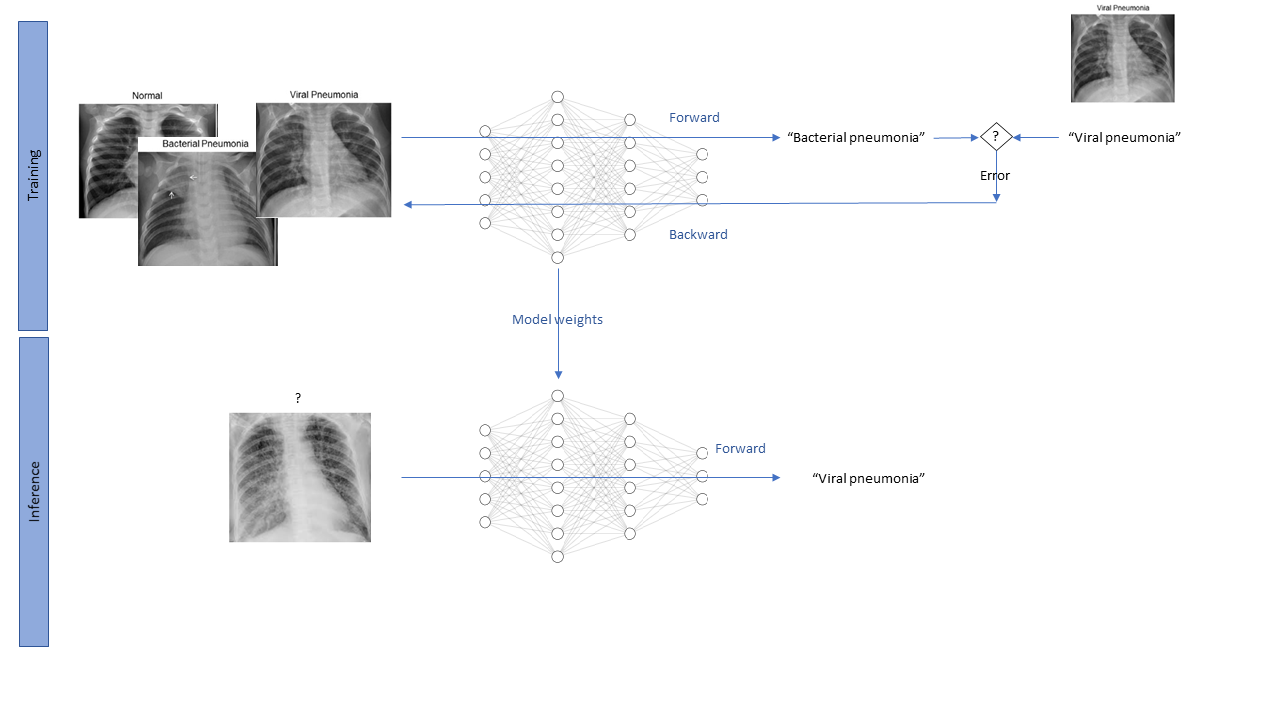

A data scientist has previously assembled a training data set consisting of thousands of CXRs, with each one labeled as being bacterial pneumonia, viral pneumonia, or no pneumonia. During the training process, as each CXR is passed to the model, the model makes a prediction (or “inference”) about what the image represents. In Figure 1, the model predicts that one image of viral pneumonia is bacterial pneumonia, which, of course, is incorrect. As this error propagates back through the model in a “backward pass”, the weights are updated to correct for the error so that the next time the same image is presented to the model, the model will more likely correctly predict that it’s viral pneumonia. This training process continues -- with the CXRs being fed to the model and the weights being updated to correct for errors, over and over again -- until the model is making predictions with the desired accuracy. At this point, the model is considered “trained” and the resulting model is ready to be used to make predictions against never-before-seen CXRs.


###Inference: Using the deep learning model

Deep learning (DL) inference is the process of using a trained deep neural network (DNN) model to make predictions against previously unseen data. As explained above, the DL training process actually involves inference, because each time an image is fed into the DNN during training, the DNN attempts to classify it. Given this, deploying a trained DNN for inference can be trivial. You could, for example, simply make a copy of a trained DNN and start using it “as is” for inference. However, for the reasons explained below, a trained DNN is often modified and simplified before being deployed for inference.


### Comparison of training and inference in terms of time :

During the DL training process, the data scientist aims to guide the model to converge and achieve the desired accuracy. This requires running dozens or perhaps hundreds of experiments, trying different model designs, and adjusting other hyperparameters (such as learning rate, batch size,etc.). Each experiment can require computations on the order of “exaflops” (or a billion billion operations), which can take hours or days to complete.
DNN models created for image classification, natural language processing, and other AI tasks can be large and complex, with dozens or hundreds of layers of artificial neurons and millions or billions of weights associated with them. The larger the DNN, the more compute, memory, and energy is consumed to run it, and the longer will be the response time (or “latency”) from when you input data to the DNN until you receive a result.
But sometimes the use case requires that inference run very fast or at very low power. For example, a self-driving car must be able to detect and respond within milliseconds in order to avoid an accident. And a battery-operated drone designed to follow a target or land in your hand has to be power-efficient to maximize flight time. In such cases, there is a desire to simplify the DNN after training in order to reduce power and latency, even if this simplification results in a slight reduction in prediction accuracy.
Even when there are no strict power or latency requirements in play, there may be a strong desire to simplify a DNN to save on energy costs. For example, large websites can easily spend millions of dollars each year just to supply power to the inference processors that enable them to auto-identify people in uploaded photos or to generate personalized news feeds for each user.

There are several ways to optimize a trained DNN in order to reduce power and latency. In one method, called “pruning”, the data scientist starts by observing the behavior of the artificial neurons across a wide array of inputs. If it turns out that a given group of artificial neurons rarely or never fire, then that group can likely be removed from the DNN without significantly degrading prediction accuracy, thus reducing the model size and improving latency. Another optimization method, called “quantization”, involves reducing the numerical precision of the weights from, say, 32-bit floating-point numbers down to 8-bit, which results in reduced model size and faster computation.
As a side note, there is an interesting parallel between optimization methods to improve inference performance and data compression techniques used to reduce the size of audio, image, or video files. Just as audio compression can reduce the file size by 80-95% with no perceptible difference in sound quality, inference optimization methods such as pruning and quantization can reduce latency by 75% with minimal reduction in prediction accuracy.


##Data preprocessing and transformation for inference

###Preprocessing:
It is crucial to understand the limitations of inference. First, the input data must be of the same nature as used during training. For example, a trained network used for brain tumor classification on axial brain MRI slices cannot be used for inference on axial brain CT slices, or even sagittal brain MRI slices. It may even require precisely the same slice thickness or even device manufacturer to work well. When an algorithm is overly sensitive to the nature of the data, it is often called 'brittle' and it is not generalized.
Second, it is crucial to understand that a preprocessing pipeline applied to training data must also be applied to inference data. As an example, consider diagnosing Alzheimer's Disease (AD) using MRI. In most cases, people use a preprocessing pipeline that includes skull stripping (zeroing out non-brain tissues), reorientation to a consistent image plane, bias field correction, and intensity normalization. Because the model was only exposed to preprocessed data during training, the model will not perform well if inference data is not handled in the same way.



###Transformation:
Data transformation includes a number of different manipulations that alter its properties, but hopefully in a way that preserves the key information. Some transformations alter the size of pixels and thus also the X, Y and Z dimensions. Since MRIs may be acquired with a variety of different pixel sizes and X, Y, and Z dimensions, it is usually a good thing to normalize the size to be consistent prior to using the data for training or inference. 
Another family of transformations alters intensity. Sometimes this is to set the grayscale range to be similar for all images. In some cases, we may wish to filter images to reduce noise. 
Another class of spatial transformations alters the primary plane of the images, for instance from Axial to Coronal or sagittal. 
In some cases, we do other types of transformations to create additional similar versions of an image that can help with generalizing the model. In these cases, we might flip the image on an axis, or rotate the image a few degrees. Adding a bit of noise or slightly altering the intensity can also help with generalization. Creating these additional versions of data is called 'augmentation'. One could do this at inference and then use a voting scheme to decide the outcome, but usually augmentation is only done for images in the training set. Yet evidence indicates that in many cases, using augmentation during inference, which is called Test Time Augmentation (TTA), will improve the performance of the model (Shanmugam et al. 2020), especially in classification and object detection tasks. 
The next cell demonstrates the difference between training and inference transformations for a hypothetical task of diagnosing AD.

In [ ]:
!pip install monai -q 
import monai as mn

train_transforms=mn.transforms.Compose([
    mn.transforms.LoadImageD(keys=["img1",'img2','img1c','imgf'],reader="NibabelReader",as_closest_canonical=False),
    mn.transforms.AddChannelD(keys=["img1",'img2','img1c','imgf']),
    mn.transforms.SpacingD(keys=["img1",'img2','img1c','imgf'],pixdim=(1,1,1), meta_key_postfix='meta_dict'),
    mn.transforms.Resized(keys=["img1",'img2','img1c','imgf'], spatial_size=(240,240,155)),
    mn.transforms.NormalizeIntensityD(keys=["img1",'img2','img1c','imgf']),
    mn.transforms.ConcatItemsd(keys=["img1", "img2",'img1c','imgf'], name="img"),
    mn.transforms.RandAffineD(
        keys="img",
        translate_range=(15,15,10),
        scale_range=(0.05,0.05,0.05),
        rotate_range=(math.pi/6,math.pi/6,math.pi/8),
        padding_mode='zeros',
        prob=0.5,
        as_tensor_output=False),
    mn.transforms.RandFlipd(keys="img", prob=0.1, spatial_axis=2)
    mn.transforms.ToTensord(keys=["img","label"]),
    
])
Inference_transforms=mn.transforms.Compose([
    mn.transforms.LoadImageD(keys=["img1",'img2','img1c','imgf'],reader="NibabelReader",as_closest_canonical=False),
    mn.transforms.AddChannelD(keys=["img1",'img2','img1c','imgf']),
    mn.transforms.SpacingD(keys=["img1",'img2','img1c','imgf'],pixdim=(1,1,1), meta_key_postfix='meta_dict'),
    mn.transforms.Resized(keys=["img1",'img2','img1c','imgf'], spatial_size=(240,240,155)),
    mn.transforms.NormalizeIntensityD(keys=["img1",'img2','img1c','imgf']),
    mn.transforms.ConcatItemsd(keys=["img1", "img2",'img1c','imgf'], name="img"),
    mn.transforms.ToTensord(keys=["img"]),
    

##Inference with torch.no_grad and eval() mode:

PyTorch's model instance has two modes: train and eval: model.train() is for training, and model.eval() is for evaluation which requires inference. The difference is that model.eval() allows the batchnorm or dropout layers to run in evaluate mode rather than training mode. In training mode, dropout is active and, as a result, in every pass, some nodes or weights will be set off randomly. In eval mode, the dropout is off and, based on the trained network, some nodes are on and others are off.
Occasionally, for uncertainty quantification, one will want to leave the dropout on in inference, but it is beyond the scope of this chapter, and we will discuss that in the future.
The gradients of tensors are tracked during training to update weights, but since we don't want to update the weights in inference, we can avoid gradient calculations using torch.no_grad(). This increases the batch size and may speed up inference by freeing up memory. 

The following code snippet illustrates how to use torch.no_grad and model.eval().

In [ ]:
  model.eval()
  with torch.no_grad():
      y_pred = torch.tensor([], dtype=torch.float32, device=device)
      for inference_data in inference_loader:
          inference_images= inferenc_data["imgs"].to(device)
          inferenc_output=model(inferenc_images)
          inferenc_epoch_len = len(inferenc_ds) // inferenc_loader.batch_size
          total_inferenc_step=(len(inferenc_ds)//bs)+1
          print(f"{inferenc_step}/{total_inferenc_step}")
          y_pred = torch.cat([y_pred, model(inferenc_images)], dim=0)
         
      binary_y_pred=y_pred.argmax(dim=1)
      print(f"Final predictions: {binary_y_pred}")

##Using visualization techniques to check the model:
When we train a model and later use it for inference, we can check it to see if it is looking at the correct features or parts of an image. This will enable us to detect potential biases or other errors. This is covered in chapter 10C ([Model Interpretation and Visualization Techniques
Validation of MIDeL algorithms](https://)).

